### lr_scheduler

In [13]:
factor = 2000
model_size = 512

batch=2
epoch=400
last_epoch = int(2889/4/batch*epoch)
warmup = 10000

In [14]:
import matplotlib.pyplot as plt

In [15]:
print(last_epoch)
plots=[]
for last_epoch in range(1, last_epoch, 1000):
    plots.append(0.0005*factor *(model_size ** (-0.5) * min((last_epoch + 1) ** (-0.5), (last_epoch + 1) * warmup ** (-1.5))))
    print(last_epoch, 0.0005*factor *(model_size ** (-0.5) * min((last_epoch + 1) ** (-0.5), (last_epoch + 1) * warmup ** (-1.5) )))


# plt.plot(plots)

144450
1 8.838834764831845e-08
1001 4.428256217180753e-05
2001 8.847673599596677e-05
3001 0.000132670909820126
4001 0.0001768650836442852
5001 0.00022105925746844442
6001 0.00026525343129260364
7001 0.00030944760511676287
8001 0.00035364177894092215
9001 0.0003978359527650813
10001 0.00044189755069578944
11001 0.00042133661245202374
12001 0.0004034021497847091
13001 0.0003875787329891794
14001 0.0003734822640651148
15001 0.00036081986438765874
16001 0.00034936378692996753
17001 0.00033893390363955725
18001 0.00032938562424114236
19001 0.0003206013617147538
20001 0.0003124843761717774
21001 0.00030495425151112895
22001 0.0002979435165599102
23001 0.0002913950834990503
24001 0.0002852602797698951
25001 0.00027949731751836194
26001 0.0002740700900788427
27001 0.0002689472159964159
28001 0.0002641012725827808
29001 0.00025950817613941966
30001 0.00025514667679243144
31001 0.00025099794370475733
32001 0.00024704522215808597
33001 0.00024327354823646427
34001 0.00023966951001522778
35001 0.0

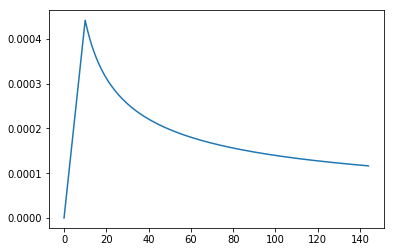

In [16]:
plt.plot(plots)


 ### Encoder Learning rate 조절

In [3]:
from bisect import bisect_right

bisect_right([50, 150, 250, 370], 100)

1

### Image Encoder 학습

In [4]:
lr = 100
for epoch in range(1, 100):
    if epoch in [25, 30, 70]:
        lr = lr * 0.1
        print(epoch, lr)



25 10.0
30 1.0
70 0.1


# BiP CA 구현


In [76]:
from pydantic import annotated_types
import torch
import torch.nn as nn
import numpy as np


# 기존의 모델에 Contrastive Attention을 적용해봅시다.

class ContraAtt(nn.Module):


    def __init__(self, cfg):
        """ 
        att_type : dot product(Default) or Bi-Linear
        embed_dim : same to input dim(Default)
        """

        super(ContraAtt, self).__init__()
        self.cfg = cfg
        self.att_type = cfg.CONTRA_ATT_TYPE
        self.att_dim = cfg.ATT_FEATS_EMBED_DIM # xtransformer : 512 (1-31, 수정(1024->512))
        self.num_heads = cfg.CONTRA_ATT_NUM_HEADS # 6 (Default)

        self.aggre_att = AggregatedAttention(self.att_dim, self.num_heads, self.att_type)
        self.diff_att = DifferentiateAttention(self.att_dim, self.att_type)
        
    
        self.update_feats = nn.Sequential(
            nn.Linear(in_features=2*self.att_dim, out_features=self.att_dim),
            nn.ReLU(),
            nn.LayerNorm(cfg.ATT_FEATS_EMBED_DIM), # Normalization 추가.
            nn.Dropout(cfg.DROPOUT_ATT_EMBED)
        )
        # self.drop_out = nn.Dropout(cfg.DROPOUT_ATT_EMBED) 

    def forward(self, input_feats, global_normal_feats):
        """
        input_feats : [196, B, 1024] (혹은 512)
        normal_feats : [B, N, 1024]
        """

        src_len = input_feats.shape[0] # 196
        global_input_feats = input_feats.mean(axis=0) # [B,1024]


        closest_normal_feats = self.aggre_att(global_input_feats, global_normal_feats) # [B, 6, 1024]  
        # print('closest_normal_feats.shape', closest_normal_feats.shape) 
        common_information = self.diff_att(global_input_feats, closest_normal_feats) # [B, 1, 7, 1024] -- 1 : num of DA heads, 6 : # num of AA heads
        # print('common_information.shape', common_information.shape)


        # basic
        # AP
        common_information = common_information.squeeze(1).mean(axis=1) # [B, 1024]
        # print('AP common information',  common_information.shape)

        diff_input_feats = global_input_feats - common_information # [B, 1024]
        # print('diff_input_feats', diff_input_feats.shape)


        # input feats[196, B, 1024] + diff_input_feats[B, 1024] 
        # --> [196, B, 1024] + [196, B, 1024] by expand diff_input_feats
        # --> [196, B, 2048]  by concat 
        # --> [196, B, 1024]  by update_feats(Linear(2048, 2012))

        diff_input_feats_par = diff_input_feats.unsqueeze(0).expand(src_len, -1, -1) # [196, B, 1024]
        # print('diff_input_feats_par', diff_input_feats_par.shape)
        # print('input_feats.shape', input_feats.shape)

        contra_feats = self.update_feats(torch.cat([input_feats, diff_input_feats_par], dim=2)) # [196, B, 1024]
        # print('contra_feats', contra_feats.shape)

        return contra_feats


class AggregatedAttention(nn.Module): # Aggregated Attention  

    def __init__(self, att_dim, num_heads, att_type):
        super(AggregatedAttention, self).__init__()
        
        self.att_dim = att_dim
        self.num_heads = num_heads
        self.att_type = att_type

        if self.att_type =='dot':
            # print('asdfsdf')
            self.att_blocks = nn.ModuleList([DotAttentionBlock(att_dim) for _ in range(num_heads)])
            # self.att_blocks = [DotAttentionBlock(att_dim) for _ in range(num_heads)]
        if self.att_type =='BiP':
            # print('asdfsdf')
            self.att_blocks = nn.ModuleList([BilinearPoolingAttentionBlock(att_dim) for _ in range(num_heads)])


        # print(self.att_blocks)

    def forward(self, global_input_feats, global_normal_feats):
        """
        input : global_input_feats : [B, 1024], global_normal_feats : [B, N, 1024]
        output : closest_normal_feats : [B, n, 1024]
        """

        closest_normal_feats = []

        for idx in range(self.num_heads):
            
            # if self.att_type =='dot':
                # [B, query_len, hid_dim] * [B, key_len, hid_dim]
            closest_normal_feat = self.att_blocks[idx](global_input_feats.unsqueeze(1), global_normal_feats) # [B, 1, 1024]
                # print('closest_normal_feat.shape', closest_normal_feat.shape)    
            # print('closest_normal_feat in AggregatedAttention.forward ', closest_normal_feat.shape)
            closest_normal_feats.append(closest_normal_feat.unsqueeze(0))

        closest_normal_feats = torch.cat(closest_normal_feats) # [n, B, 1, 1024] (n=6)
        # print('closest_normal_feats.shape', closest_normal_feats.shape)
        closest_normal_feats = closest_normal_feats.permute(1,0,2,3) # [B, n, 1, 1024] 
        closest_normal_feats = closest_normal_feats.squeeze(2) # [B, n, 1024]

        return closest_normal_feats

class DifferentiateAttention(nn.Module): # Aggregated Attention  

    def __init__(self, att_dim, att_type, num_heads = 1):
        super(DifferentiateAttention, self).__init__()
        
        self.att_dim = att_dim
        self.att_type = att_type
        self.num_heads = num_heads # Default : 1

        if self.att_type =='dot':
            self.att_blocks = nn.ModuleList([DotAttentionBlock(att_dim) for _ in range(num_heads)])
        if self.att_type =='BiP':
            self.att_blocks = nn.ModuleList([BilinearPoolingAttentionBlock(att_dim) for _ in range(num_heads)])

    def forward(self, global_input_feats, closest_normal_feats):
        """
        input : global_input_feats ([B, hid_dim]), cloasest_normal_feats ([B, n, hid_dim]
        output : diff_att_feats ([B, 1+n, hid_dim]) """


        common_feats = torch.cat([global_input_feats.unsqueeze(1), closest_normal_feats], axis=1) # [B, n+1, hid_dim]

        common_att_feats=[]


        for idx in range(self.num_heads): # default : 1 
            # if self.att_type =='dot':
            common_att_feat = self.att_blocks[idx](common_feats, common_feats) # [B, n+1, hid_dim]
                # print('common_att_feat.shape', common_att_feat.shape)
            # print('closest_normal_feat in AggregatedAttention.forward ', closest_normal_feat.shape)
            common_att_feats.append(common_att_feat.unsqueeze(0))

        common_att_feats = torch.cat(common_att_feats) # [1, B, n+1, hid_dim] (n=6)
        # print('common_att_feats.shape', common_att_feats.shape)

        common_att_feats = common_att_feats.permute(1,0,2,3) # [B, 1, n+1, hid_dim]  (1 : DA의 head 개수, n : AA의 head 개수)
        # print('Final common_att_feats.shape', common_att_feats.shape)
        return common_att_feats

class DotAttentionBlock(nn.Module):
   
    def __init__(self, hid_dim):
        super(DotAttentionBlock, self).__init__()
        self.hid_dim = hid_dim
        self.scale = torch.sqrt(torch.FloatTensor([self.hid_dim])) #.cuda()
        self.proj_input = nn.Linear(in_features=hid_dim, out_features = hid_dim)
        self.proj_normal = nn.Linear(in_features=hid_dim, out_features=hid_dim)

    def forward(self, global_input_feats, global_normal_feats):
        """
        input : global_input_feats([B, 1 hid_dim]), global_normal_feats([B, N, hid_dim])
        output : closeset_normal_feat([B, 1, hid_dim])
        """

        # for key,value in self.proj_input.named_parameters():
        #     print(key, value.requires_grad, value.device)

        # print('glo device', global_input_feats.device)

        Q = self.proj_input(global_input_feats) # [B, 1, hid_dim]
        K = self.proj_normal(global_normal_feats) # [B, N, hid_dim]

        # Q'


        # print('Q', Q.shape)
        # print('K', K.shape)
        # print('K.permute(0,2,1)', K.permute(0,2,1).shape)
        
        # # cuda or gpu
        # if self.scale.device != global_input_feats.device:
        #    self.scale = self.scale.to(global_input_feats.device)

        # Attention Value
        M = torch.matmul(Q, K.permute(0,2,1))/self.scale # [B, 1, N] 
        # print('M', M.shape)

        # Attention map
        # print('M', M)
        # print('M', M)
        attention = torch.softmax(M, dim=-1) # [B, 1, N}
        # print('Attention', attention)
        # print('attention', attention.shape)
        

        closest_normal_feats = torch.matmul(attention, global_normal_feats) # [B, 1, hid_dim] (=[B, 1, N] * [B, N, hid_dim])
        
        
        return closest_normal_feats
        


class BilinearPoolingAttentionBlock(nn.Module):
    
    def __init__(self, hid_dim):

        super(BilinearPoolingAttentionBlock, self).__init__()

        self.hid_dim = hid_dim
        squeeze_dim = int(hid_dim/2)
        self.squeeze_dim = squeeze_dim

        self.scale = torch.sqrt(torch.FloatTensor([self.hid_dim])) #.cuda()

        self.proj_input_key = nn.Linear(in_features=hid_dim, out_features = hid_dim)
        self.proj_normal_key = nn.Linear(in_features=hid_dim, out_features= hid_dim)
        self.proj_input_value = nn.Linear(in_features=hid_dim, out_features = hid_dim)
        self.proj_normal_value = nn.Linear(in_features=hid_dim, out_features= hid_dim)
        
        self.embed1 = nn.Linear(in_features =  hid_dim, out_features = squeeze_dim) # : self.squeeze
        self.embed2 = nn.Linear(in_features = squeeze_dim, out_features = 1)
        self.excitation = nn.Linear(in_features = squeeze_dim, out_features = hid_dim)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, global_input_feats, global_normal_feats):
        """
        input : global_input_feats([B, 1 hid_dim]), global_normal_feats([B, N, hid_dim])
        output : closeset_normal_feat([B, 1, hid_dim])
        """
        global beta_s, B_v, beta_c, att_v, v_hat
        B, N, hid_dim = global_normal_feats.shape

        # Query - Key Bilinear Pooling
        Q_k = self.proj_input_key(global_input_feats) # [B, 1, hid_dim]
        K = self.proj_normal_key(global_normal_feats) # [B, N, hid_dim]
        
        ## B_k = [B, N, hid_dim] * [B, N, hid_dim]
        B_k = self.sigmoid(Q_k.expand(-1, N, -1)) * self.sigmoid(K) # expand는 생략해도 무방하나, 직관성을 위해 표기 
        
        # print('Q_k', Q_k.shape) # [B, 1, hid_dim]
        # print('K', K.shape) # [B, N, hid_dim]
        # print('B_k', B_k.shape) # [B, N, hid_dim]

        # embed 1 (squeeze)
        B_k_prime = self.relu(self.embed1(B_k)) # [B, N, hid_dim/2]
        # print('B_k_prime', B_k_prime.shape) 
        
        # spatial attention (beta_s)
        b_s = self.embed2(B_k_prime) # [B, N, 1]
        # print('b_s', b_s.shape)

        beta_s = b_s.softmax(dim=1) # [B, N, 1]
        # print('beta_s', beta_s.shape)

        # channel-wise attention (excitation) (beta_c)

        B_bar = B_k_prime.mean(dim=1) # [B, hid_dim/2]
        # print('B_bar', B_bar.shape)

        b_c = self.excitation(B_bar) # [B, hid_dim]
        beta_c = self.sigmoid(b_c) # [B, hid_dim]
        # print('beta_c', beta_c.shape)

        

        # Query - Value Bilinear Pooling

        Q_v = self.proj_input_value(global_input_feats) # [B, 1, hid_dim] 
        V = self.proj_normal_value(global_normal_feats) # [B, N, hid_dim]

        B_v = self.relu(Q_v.expand((-1, N, -1))) * self.relu(V)   # expand : [B, 1, hid_dim] -> [B, N, hid_dim]
        
        # print('Q_v', Q_v.shape) # [B, 1, hid_dim]
        # print('V', V.shape) # [B, N, hid_dim]
        # print('B_v', B_v.shape) # [B, N, hid_dim]
        
        
        # spatial-attended value (논문 내 식 (6))
        att_v=(B_v*beta_s).sum(dim=1) # [B, hid_dim]
        # print('att_v', att_v.shape) # [B, hid_dim]
        
        ## 아래 식으로 해도 상관은 없다.
        ## Att_v = torch.matmul(beta_s.permute(0,2,1), B_v).squeeze(1)

        v_hat=beta_c * att_v # [B, hid_dim]
        # print('v_hat', v_hat.shape) # [B, hid_dim]
        
        v_hat = v_hat.unsqueeze(1) # [B, 1, hid_dim]
        
        # print('v_hat', v_hat.shape) # [B, hid_dim]
        
           
        return v_hat


In [69]:
import easydict

In [92]:
# input
input_feats = torch.rand((49, 2, 16)).cpu()
normal_feats = torch.rand((2, 5, 16)).cpu()

In [93]:
# config
cfg=  easydict.EasyDict
cfg.CONTRA_ATT_TYPE ='dot'
cfg.ATT_FEATS_EMBED_DIM=16
cfg.CONTRA_ATT_NUM_HEADS = 3
cfg.DROPOUT_ATT_EMBED = 0.3



# model
contra_att = ContraAtt(cfg)
contra_att.eval()

pass

In [101]:
contra_feats_dot = contra_att(input_feats, normal_feats)

In [103]:
print(contra_feats_dot.shape)

torch.Size([49, 2, 16])


In [104]:
print(contra_feats_dot[:5, 0, :5])

tensor([[-0.7876,  1.7939,  1.2440, -0.7876, -0.7876],
        [ 0.0994, -0.4149,  2.0619, -0.8139,  0.7776],
        [-0.7227,  0.8419,  1.9502, -0.7595, -0.6045],
        [-0.8030,  0.9398,  1.4645, -0.8030, -0.2329],
        [-0.7981,  0.9300,  0.0852, -0.7981, -0.7981]],
       grad_fn=<SliceBackward0>)


In [105]:
# config
cfg=  easydict.EasyDict
cfg.CONTRA_ATT_TYPE ='BiP'
cfg.ATT_FEATS_EMBED_DIM=16
cfg.CONTRA_ATT_NUM_HEADS = 3
cfg.DROPOUT_ATT_EMBED = 0.3


# model
contra_att = ContraAtt(cfg)
contra_att.eval()

pass

In [106]:
contra_feats_bip = contra_att(input_feats, normal_feats)

In [107]:
print(contra_feats_bip.shape)

torch.Size([49, 2, 16])


In [108]:
print(contra_feats_bip[:5, 0, :5])

tensor([[-0.7759, -0.7759, -0.4321,  0.3739,  1.4593],
        [-0.8710, -0.8710, -0.0942,  0.6868,  1.2801],
        [-0.8355, -0.8355, -0.8355,  0.5541,  1.5611],
        [-0.7468, -0.7468, -0.1552,  0.0255,  1.2583],
        [-0.9392, -0.9392, -0.8304,  0.5949,  1.2941]],
       grad_fn=<SliceBackward0>)


In [109]:
print(contra_feats_dot[:5, 0, :5])

tensor([[-0.7876,  1.7939,  1.2440, -0.7876, -0.7876],
        [ 0.0994, -0.4149,  2.0619, -0.8139,  0.7776],
        [-0.7227,  0.8419,  1.9502, -0.7595, -0.6045],
        [-0.8030,  0.9398,  1.4645, -0.8030, -0.2329],
        [-0.7981,  0.9300,  0.0852, -0.7981, -0.7981]],
       grad_fn=<SliceBackward0>)


In [111]:
import matplotlib.pyplot as plt

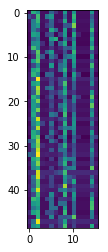

In [115]:
plt.imshow(contra_feats_dot[:, 0, :].detach().numpy())

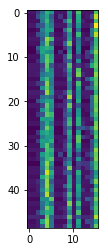

In [116]:
plt.imshow(contra_feats_bip[:, 0, :].detach().numpy())

# Gradient 확인

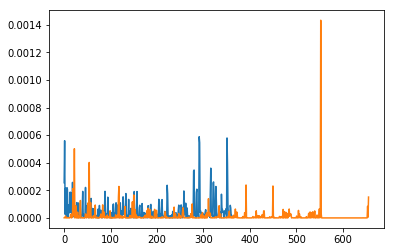

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
grad = pd.read_pickle('grad.pickle')

plt.plot([abs(grad) for grad in grad['extractor']])
plt.plot([abs(grad) for grad in grad['transformer']])

In [16]:
print(np.mean([abs(grad) for grad in grad['extractor']]))
print(np.mean([abs(grad) for grad in grad['transformer']]))

5.145878604389933e-06
1.3757963422039753e-05


# Validation data 확인

In [ ]:
data_root = './mimic/sent/mimic_train_input.pkl'

In [ ]:
data_root = './mimic/sent/mimic_train_input.pkl'

In [ ]:
import pandas as pd
import pickle
index=865


In [ ]:
index+=1
pd.read_pickle(data_root)[f'{index}']


sss